In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, asc, desc, regexp_replace, translate, udf, array
from pyspark.sql.types import StringType


spark = SparkSession.builder.getOrCreate()

21/10/31 22:11:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Countries data preparation

In [2]:
df_countries = spark.read.csv('data/countries of the world.csv',header=True, inferSchema="true")

# mistake in data (values are in meters instead of miles)
df_countries = df_countries.withColumnRenamed('Pop. Density (per sq. mi.)', 'Pop Density (per sq km)')
df_countries = df_countries.withColumnRenamed('Area (sq. mi.)', 'Area (sq km)')
# task 4 (empty line at the end of the name)
df_countries = df_countries.withColumn('Country', regexp_replace('Country', '\s+$', ''))
df_countries = df_countries.withColumn('Region', regexp_replace('Region', '\s+$', ''))

to_float_columns = ['Infant mortality (per 1000 births)', 'Literacy (%)', 'Pop Density (per sq km)']
for fc in to_float_columns:
    df_countries = df_countries.withColumn(fc, regexp_replace(fc, '\\,', '\\.').cast("float"))

df_countries

DataFrame[Country: string, Region: string, Population: int, Area (sq km): int, Pop Density (per sq km): float, Coastline (coast/area ratio): string, Net migration: string, Infant mortality (per 1000 births): float, GDP ($ per capita): int, Literacy (%): float, Phones (per 1000): string, Arable (%): string, Crops (%): string, Other (%): string, Climate: string, Birthrate: string, Deathrate: string, Agriculture: string, Industry: string, Service: string]

In [3]:
df_countries.head()

Row(Country='Afghanistan', Region='ASIA (EX. NEAR EAST)', Population=31056997, Area (sq km)=647500, Pop Density (per sq km)=48.0, Coastline (coast/area ratio)='0,00', Net migration='23,06', Infant mortality (per 1000 births)=163.07000732421875, GDP ($ per capita)=700, Literacy (%)=36.0, Phones (per 1000)='3,2', Arable (%)='12,13', Crops (%)='0,22', Other (%)='87,65', Climate='1', Birthrate='46,6', Deathrate='20,34', Agriculture='0,38', Industry='0,24', Service='0,38')

### Airports data preparation

In [4]:
df_airports = spark.read.csv('data/airports.csv', header=False, inferSchema="true")
df_airports

DataFrame[_c0: int, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: double, _c7: double, _c8: int, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string]

In [5]:
airports_columns_names = [
    'Airport ID', 
    'Name', 
    'City', 
    'Country',
    'IATA', 
    'ICAO', 
    'Latitude', 
    'Longitude', 
    'Altitude', 
    'Timezone', 
    'DST', 
    'Tz database time zone', 
    'Type', 
    'Source'
]

for col_old, col_new in zip(df_airports.schema.names, airports_columns_names):
    print(f'Renaming {col_old} to {col_new}.')
    df_airports = df_airports.withColumnRenamed(col_old, col_new)
    
df_airports.head()

Renaming _c0 to Airport ID.
Renaming _c1 to Name.
Renaming _c2 to City.
Renaming _c3 to Country.
Renaming _c4 to IATA.
Renaming _c5 to ICAO.
Renaming _c6 to Latitude.
Renaming _c7 to Longitude.
Renaming _c8 to Altitude.
Renaming _c9 to Timezone.
Renaming _c10 to DST.
Renaming _c11 to Tz database time zone.
Renaming _c12 to Type.
Renaming _c13 to Source.


Row(Airport ID=1, Name='Goroka Airport', City='Goroka', Country='Papua New Guinea', IATA='GKA', ICAO='AYGA', Latitude=-6.081689834590001, Longitude=145.391998291, Altitude=5282, Timezone='10', DST='U', Tz database time zone='Pacific/Port_Moresby', Type='airport', Source='OurAirports')

### Task 1

Narysuj wykres zależności kolumn Plot Infant mortality vs. Literacy dla 30 najbogatszych i 30 najbiedniejszych krajów

In [6]:
richest_countries = df_countries.sort(desc("GDP ($ per capita)"))\
    .select(col("Country"), col("Infant mortality (per 1000 births)"), col("Literacy (%)"))\
    .where(col("Literacy (%)").isNotNull())\
    .head(30)

df_richest = pd.DataFrame(richest_countries,columns=["Country", "Infant Mortality", "Literacy"])

df_richest

,Country,Infant Mortality,Literacy
0,Luxembourg,4.81,100.000000
1,Norway,3.70,100.000000
2,United States,6.50,97.000000
3,Bermuda,8.53,98.000000
4,Cayman Islands,8.19,98.000000
5,San Marino,5.73,96.000000
6,Switzerland,4.39,99.000000
7,Denmark,4.56,100.000000
8,Iceland,3.31,99.900002
9,Austria,4.66,98.000000


<AxesSubplot:xlabel='Infant Mortality', ylabel='Literacy'>

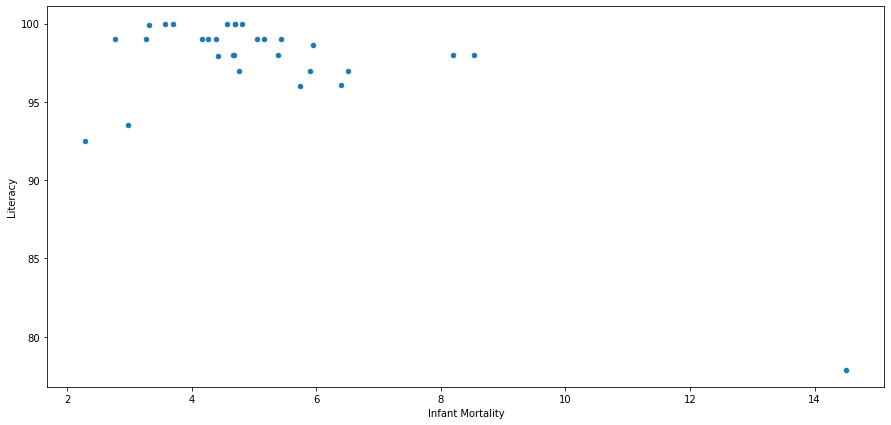

In [7]:
df_richest.plot.scatter(x="Infant Mortality", y="Literacy",figsize=(15,7))

### Task 2

Wczytaj zbiór danych "airports.csv" ze strony https://www.kaggle.com/jonatancr/airports (zawiera on dane na temat lotnisk z całego świata). Ponieważ w zbiorze tym nie ma nagłówka, nadaj własne nazwy kolumnom, korzystając z opisu pliku na stronie https://openflights.org/data.html. Narysuj na wykresie (mapie) położenia wszystkich/wybranych lotnisk.

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

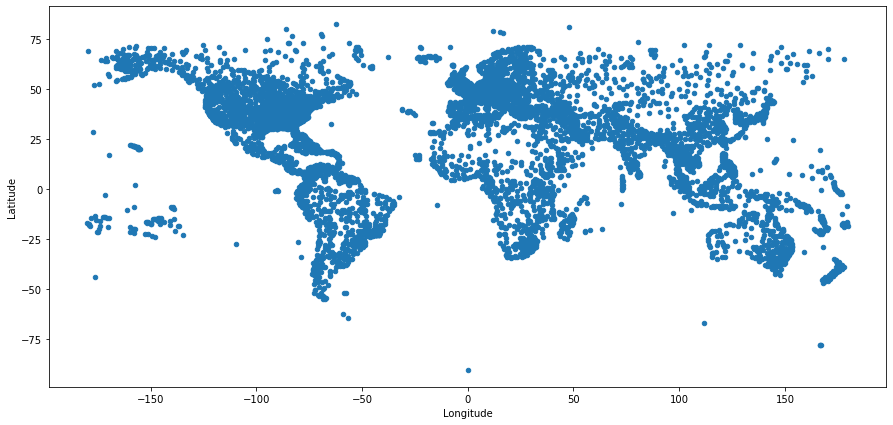

In [8]:
df_airports.select(col("Latitude"), col("Longitude"))\
    .toPandas()\
    .plot.scatter(x="Longitude", y="Latitude",figsize=(15,7))

### Task 3
Utwórz dwie nowe kolumny w ramce "Countries", w których powierzchnia i gęstość zaludnienia wyrażone sa odpowiednio w milach kwadratowych i osobach na milę kwadratową

In [9]:
#  'Area (sq mi)' oraz 'Pop Density (per sq mi)'
df_countries = df_countries.withColumn('Area (sq mi)', col('Area (sq km)')/2.59)
df_countries = df_countries.withColumn('Pop Density (per sq mi)', col('Pop Density (per sq km)')*2.59)

In [10]:
df_countries.head()

Row(Country='Afghanistan', Region='ASIA (EX. NEAR EAST)', Population=31056997, Area (sq km)=647500, Pop Density (per sq km)=48.0, Coastline (coast/area ratio)='0,00', Net migration='23,06', Infant mortality (per 1000 births)=163.07000732421875, GDP ($ per capita)=700, Literacy (%)=36.0, Phones (per 1000)='3,2', Arable (%)='12,13', Crops (%)='0,22', Other (%)='87,65', Climate='1', Birthrate='46,6', Deathrate='20,34', Agriculture='0,38', Industry='0,24', Service='0,38', Area (sq mi)=250000.0, Pop Density (per sq mi)=124.32)

### Task 4
Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju.

#### Data unification

In [11]:
def check_not_matching_countries(df_countries,  df_airports):
    country_pairs = df_airports.join(df_countries,  df_airports.Country == df_countries.Country, 'outer')\
        .select(df_airports.Country.alias("AirportCountry"), df_countries.Country)\

    matching_countries = country_pairs\
        .where(col('AirportCountry').isNotNull() & col('Country').isNotNull())\
        .distinct()\
        .count()


    not_matching_countries = country_pairs.where(col('AirportCountry').isNull() | col('Country').isNull())\
        .distinct()

    airtport_countries_names = not_matching_countries.select(col('AirportCountry'))\
        .where(col('AirportCountry').isNotNull())\
        .sort(asc('AirportCountry'))\
        .collect()
    countries_names = not_matching_countries.select(col('Country'))\
        .where(col('Country').isNotNull())\
        .sort(asc('Country'))\
        .collect() 
    
    return matching_countries, airtport_countries_names, countries_names

In [12]:
matching_countries, airtport_countries_names,countries_names = check_not_matching_countries(df_countries,  df_airports)
print(f'Number of matching countries {matching_countries}')
print(airtport_countries_names)
print(countries_names)

Number of matching countries 205
[Row(AirportCountry='Antarctica'), Row(AirportCountry='Antigua and Barbuda'), Row(AirportCountry='Bahamas'), Row(AirportCountry='Bosnia and Herzegovina'), Row(AirportCountry='British Indian Ocean Territory'), Row(AirportCountry='British Virgin Islands'), Row(AirportCountry='Central African Republic'), Row(AirportCountry='Christmas Island'), Row(AirportCountry='Cocos (Keeling) Islands'), Row(AirportCountry='Congo (Brazzaville)'), Row(AirportCountry='Congo (Kinshasa)'), Row(AirportCountry='Falkland Islands'), Row(AirportCountry='Gambia'), Row(AirportCountry='Johnston Atoll'), Row(AirportCountry='Micronesia'), Row(AirportCountry='Midway Islands'), Row(AirportCountry='Montenegro'), Row(AirportCountry='Myanmar'), Row(AirportCountry='Niue'), Row(AirportCountry='Norfolk Island'), Row(AirportCountry='North Korea'), Row(AirportCountry='Northern Mariana Islands'), Row(AirportCountry='Palestine'), Row(AirportCountry='Saint Kitts and Nevis'), Row(AirportCountry='Sa

In [13]:
country_mappings = {
    'Antigua and Barbuda': 'Antigua & Barbuda',
    'Bahamas': 'Bahamas, The',
    'Bosnia and Herzegovina': 'Bosnia & Herzegovina',
    'North Korea': 'Korea, North',
    'Micronesia': 'Micronesia, Fed. St.',
    'South Korea': 'Korea, South'
}

In [14]:
df_airports = df_airports.na.replace(country_mappings)
df_airports.head()

Row(Airport ID=1, Name='Goroka Airport', City='Goroka', Country='Papua New Guinea', IATA='GKA', ICAO='AYGA', Latitude=-6.081689834590001, Longitude=145.391998291, Altitude=5282, Timezone='10', DST='U', Tz database time zone='Pacific/Port_Moresby', Type='airport', Source='OurAirports')

In [15]:
matching_countries_after_change, _, _ = check_not_matching_countries(df_countries,  df_airports)
print(f'Number of matching countries after change {matching_countries_after_change}')

Number of matching countries after change 211


#### Plot

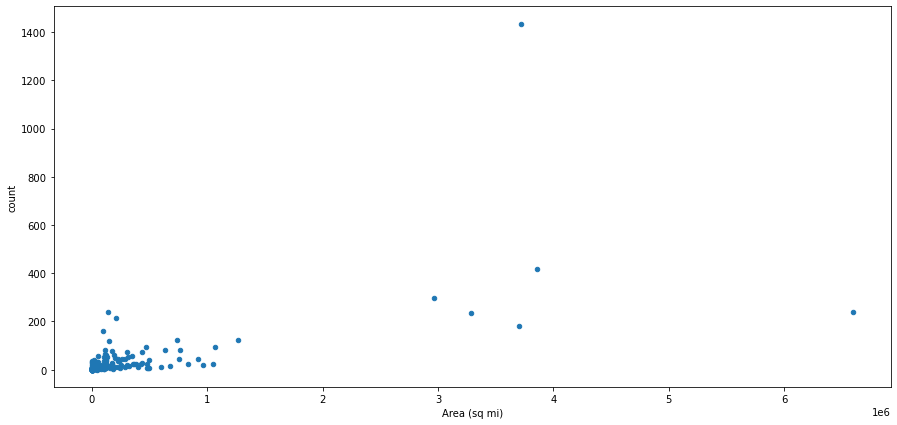

In [16]:
count_by_country = df_airports.join(df_countries,  df_airports.Country == df_countries.Country, 'inner')\
        .select(df_countries.Country, df_countries['Area (sq mi)'])\
        .groupBy([df_countries.Country, df_countries['Area (sq mi)']])\
        .count()\
        .toPandas()\
        .plot.scatter(x="Area (sq mi)", y="count",figsize=(15,7))

### Task 5

Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie słupkowym.

In [17]:
df_countries.select(col('Region')).distinct().show()

+--------------------+
|              Region|
+--------------------+
| C.W. OF IND. STATES|
|      EASTERN EUROPE|
|    NORTHERN AMERICA|
|ASIA (EX. NEAR EAST)|
|             OCEANIA|
|      WESTERN EUROPE|
|           NEAR EAST|
|  SUB-SAHARAN AFRICA|
|             BALTICS|
| LATIN AMER. & CARIB|
|     NORTHERN AFRICA|
+--------------------+



In [18]:
AFRICA = 'Africa'
ASIA = 'Asia'
EUROPE = 'Europe'
N_AMERICA = 'North America'
S_AMERICA = 'South America' 
ANTARCTICA = 'Antarctica'
AUSTRALIA_OCEANIA = 'Australia/Oceania'

continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Antarctica', 'Australia/Oceania']

def classify_region(country, region):
    if region == 'C.W. OF IND. STATES':
        if country == 'Belarus':
            return EUROPE
        else:
            return ASIA
    elif region in ['EASTERN EUROPE', 'WESTERN EUROPE', 'BALTICS']:
        return EUROPE
    elif region in ['NORTHERN AMERICA']:
        return N_AMERICA
    elif region in ['LATIN AMER. & CARIB']:
        return S_AMERICA
    elif region in ['SUB-SAHARAN AFRICA', 'NORTHERN AFRICA']:
        return AFRICA
    elif region in ['ASIA (EX. NEAR EAST)', 'NEAR EAST']:
        return ASIA
    elif region in ['OCEANIA']:
        return AUSTRALIA_OCEANIA
    
    raise Exception("Unknown region")

In [19]:
classify_region_udf = udf(lambda arr: classify_region(arr[0], arr[1]), StringType())

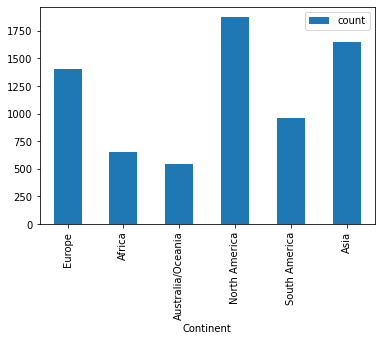

In [20]:
df_countries_continents = df_countries.withColumn('Continent', classify_region_udf(array('Country', 'Region')))

count_by_continent = df_airports.join(df_countries_continents,  df_airports.Country == df_countries_continents.Country, 'inner')\
        .select(df_countries_continents.Continent)\
        .groupBy(df_countries_continents.Continent)\
        .count()\
        .toPandas()\
        .plot.bar(x='Continent', y='count')